# Example Serial Position Cells Visualization

This notebook contains plots of example cells from the spatial target analysis. 

In [1]:
%config Completer.use_jedi = False

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from scipy.stats import sem, ttest_rel

from convnwb.io import load_nwbfile
from convnwb.io import get_files, save_json

from spiketools.measures.trials import compute_segment_frs
from spiketools.measures.spikes import compute_firing_rate
from spiketools.measures.conversions import convert_times_to_rates
from spiketools.stats.shuffle import shuffle_spikes
from spiketools.stats.permutations import compute_surrogate_stats
from spiketools.utils import set_random_seed
from spiketools.utils.base import select_from_list
from spiketools.utils.data import compute_range
from spiketools.utils.extract import (get_range, get_value_by_time, get_values_by_time_range,
                                      get_values_by_times, threshold_spikes_by_times)
from spiketools.utils.epoch import (epoch_data_by_range, epoch_spikes_by_segment, 
                                    epoch_spikes_by_range, epoch_spikes_by_event)

from spiketools.plts.data import plot_bar
from spiketools.plts.spatial import plot_heatmap, plot_positions, create_heat_title
from spiketools.plts.trials import plot_rasters
from spiketools.plts.stats import plot_surrogates
from spiketools.plts.utils import make_axes, save_figure, make_grid, get_grid_subplot

In [3]:
import sys
sys.path.append('../code')

from models import *
from utils import *
from plts import *

In [4]:
import seaborn as sns
sns.set_context('talk')

## Settings

In [5]:
# Define the base data folder
data_folder = '/Users/Claire_han/Documents/Data/JacobsLab/WVTH/nwb'
# data_folder = '/Users/clairehan/Documents/Data/JacobsLab/WVTH/nwb'

In [6]:
# Define session information
session = {
    'experiment' : 'THO',
    'subject' : 'wv001',
    'session' : 2
}

In [7]:
# Set which example unit to extract
uind = 0

In [8]:
# Define occupancy settings: minimum required occupancy (in seconds) & speed threshold
min_occ = 1
speed_thresh = 5e-6
time_thresh = 0.25

In [9]:
# Shuffle Settings
shuffle_approach = 'CIRCULAR'  # 'CIRCULAR', 'BINCIRC'
n_surrogates = 25

if shuffle_approach == 'CIRCULAR':
    shuffle_kwargs = {}
if shuffle_approach == 'BINCIRC':
    shuffle_kwargs = {}
    #shuffle_kwargs = {'shuffle_min' : 20000}

In [10]:
# Set which analysis method to run
METHOD = 'ANOVA'  # 'SEGMENT' / 'ANOVA'

## Load data

In [11]:
# Get the list of NWB files
nwbfiles = get_files(data_folder)

In [12]:
# Load example NWB file
nwbfile = load_nwbfile(session, data_folder)

### Get trial data

In [13]:
# Get the number of trials
n_trials = len(nwbfile.trials)
print('Number of trials: {}'.format(n_trials))

Number of trials: 24


In [14]:
nav_starts = nwbfile.trials.navigation_start[:]
nav_stops = nwbfile.trials.navigation_stop[:]
chest_openings = nwbfile.trials['chest_opening_time'][:]
ch_openings_all = np.array(chest_openings).reshape(-1,1)

### Get spike data

In [15]:
# Check the number of units & keep indices
n_units = len(nwbfile.units)
keep_inds = np.where(nwbfile.units.keep[:])[0]
n_keep = len(keep_inds)
print('Number of units: {}'.format(n_units))
print('Number to keep:  {}'.format(n_keep))

Number of units: 118
Number to keep:  85


In [16]:
# Get spikes
spikes = nwbfile.units.get_unit_spike_times(uind)

In [17]:
# Define the segment times of interest
seg_times = np.insert(np.array(chest_openings), 0, nav_starts, axis=1)
# chest_trial_number = np.array(list(range(len(chest_trials)))).reshape(n_trials,4)

## One example serial position cell

#### Time spend in each serial position

In [18]:
segment_frs = compute_segment_frs(spikes, seg_times)

In [19]:
seg_interval = np.zeros([seg_times.shape[0], 4])
for ind in range(seg_times.shape[0]):
    seg_interval[ind, :] = (np.diff(seg_times[ind])).tolist()

#### Spike count in each serial position

In [20]:
tseg_count = np.zeros([seg_times.shape[0], 4])
for ind, time in enumerate(seg_times):
    segment_spikes = epoch_spikes_by_segment(spikes, time)
    tseg_count[ind, :] = np.array([len(segment_spikes[0]), len(segment_spikes[1]), len(segment_spikes[2]), len(segment_spikes[3])])

seg_counts = np.sum(tseg_count, 0)

#### Normalized raster plot 

In [21]:
trials_sp = epoch_spikes_by_range(spikes, nav_starts, np.array(chest_openings)[:,3], reset=False)
t_spikes = np.concatenate(trials_sp).ravel()

In [22]:
s0_spikes = normalize_segment_spikes(t_spikes, nav_starts, np.array(chest_openings)[:,0], (0, 1))
s1_spikes = normalize_segment_spikes(t_spikes, np.array(chest_openings)[:,0], np.array(chest_openings)[:,1], (1, 2))
s2_spikes = normalize_segment_spikes(t_spikes, np.array(chest_openings)[:,1], np.array(chest_openings)[:,2], (2, 3))
s3_spikes = normalize_segment_spikes(t_spikes, np.array(chest_openings)[:,2], np.array(chest_openings)[:,3], (3, 4))

In [23]:
spikes_trial = [np.hstack([s0_spikes[ind], s1_spikes[ind], s2_spikes[ind], s3_spikes[ind]])
                    for ind in range(n_trials)]

#### Surrogate Distribution

In [24]:
# Create shuffled time series for comparison
times_shuffle = shuffle_spikes(spikes, shuffle_approach, n_surrogates, **shuffle_kwargs)

In [25]:
# Create dataframe
df = create_df_serial(segment_frs)

In [26]:
# Fit the ANOVA, and get f-value
f_val = fit_anova_serial(df)

In [27]:
# Compute measures across shuffled time series for comparison
surrogates = np.zeros(n_surrogates)
for ind, shuffle in enumerate(times_shuffle):
    segment_frs = compute_segment_frs(shuffle, seg_times)
    df = create_df_serial(segment_frs)
    surrogates[ind] = fit_anova_serial(df)

In [28]:
# Compute surrogate statistics
p_val, z_score = compute_surrogate_stats(f_val, surrogates, verbose=False)

## Create report for significant cell

In [29]:
name = nwbfile.session_id + '_U' + str(uind).zfill(2)

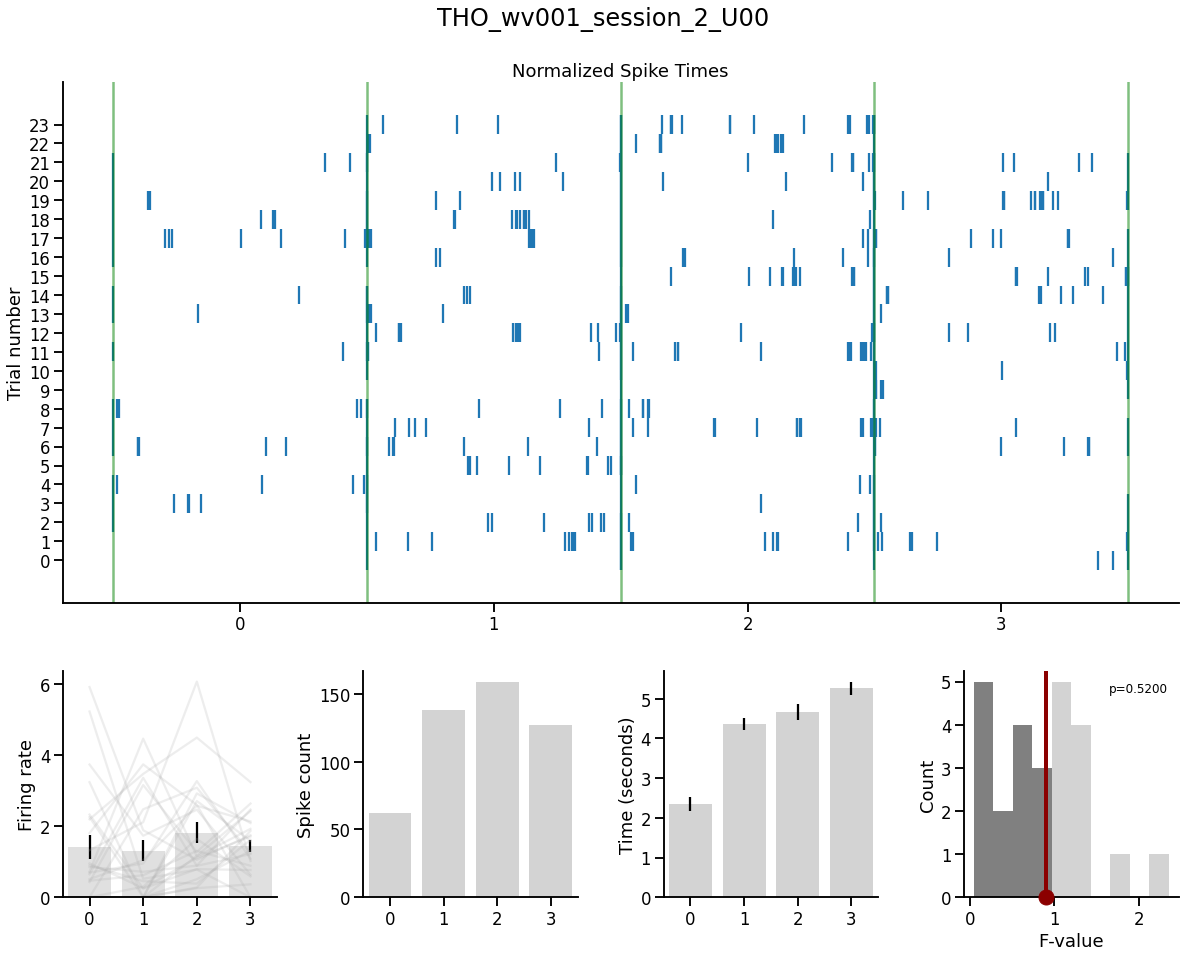

In [30]:
grid = make_grid(3, 4, figsize=(20, 15), wspace=0.4, hspace=0.3, title=name)

plot_rasters(spikes_trial, vline=[0, 1, 2, 3, 4], show_axis=True,
             ax=get_grid_subplot(grid, slice(0, 2), slice(0, 4)),
                  title="Normalized Spike Times", ylabel="Trial number", 
                  xticks=[0.5, 1.5, 2.5, 3.5], yticks=range(0,len(spikes_trial)), xticklabels=[0,1,2,3])

plot_bar(segment_frs.mean(0), [0, 1, 2, 3], yerr=sem(segment_frs, 0), alpha=0.7, color="lightgray", 
         ax=get_grid_subplot(grid, 2, 0), ylabel='Firing rate')
for ind in range(len(segment_frs[:,0])): 
    get_grid_subplot(grid, 2, 0).plot(['0','1','2','3'], segment_frs[ind], color='darkgray', alpha=0.2)
plot_bar(seg_counts, [0,1,2,3], ax=get_grid_subplot(grid, 2, 1), color='lightgray', ylabel='Spike count')
plot_bar(seg_interval.mean(0), [0, 1, 2, 3], yerr=sem(seg_interval, 0), color='lightgray',
         ylabel='Time (seconds)', ax=get_grid_subplot(grid, 2, 2))
plot_surr_stats(surrogates, f_val, p_val, 10, ax=get_grid_subplot(grid, 2, 3))

# Drop after spiketools update
get_grid_subplot(grid, slice(0, 2), slice(0, 4)).spines.right.set_visible(False)
get_grid_subplot(grid, slice(0, 2), slice(0, 4)).spines.top.set_visible(False)
get_grid_subplot(grid, 2, 0).spines.right.set_visible(False)
get_grid_subplot(grid, 2, 0).spines.top.set_visible(False)
get_grid_subplot(grid, 2, 1).spines.right.set_visible(False)
get_grid_subplot(grid, 2, 1).spines.top.set_visible(False)
get_grid_subplot(grid, 2, 2).spines.right.set_visible(False)
get_grid_subplot(grid, 2, 2).spines.top.set_visible(False)
get_grid_subplot(grid, 2, 3).spines.right.set_visible(False)
get_grid_subplot(grid, 2, 3).spines.top.set_visible(False)

## All significant target cells

In [31]:
# Load & merge the results sheets of THF & THO
# df_THF = pd.read_excel("/Users/clairehan/Desktop/THF_all_results.xlsx")
# df_THO = pd.read_excel("/Users/clairehan/Desktop/THO_all_results.xlsx")
df_THF = pd.read_excel("/Users/Claire_han/Desktop/research/WVTH/THF_all_results.xlsx")
df_THO = pd.read_excel("/Users/Claire_han/Desktop/research/WVTH/THO_all_results.xlsx")
df = df_THF.append(df_THO)

In [32]:
# Create a dataframe for significant spatial target cells
df_sp = df[df.is_sp_cell]
df_sp.head()

,Unnamed: 0,session,uid,wvID,keep,cluster,channel,location,n_spikes,firing_rate,...,sp_p_val,sp_z_score,area,fr_keep_th,is_chest_cell,is_full_cell,is_empty_cell,is_place_cell,is_target_cell,is_sp_cell
6,6,THF_wv001_session_0,8,9,1,2248,A15,LAH,1079,0.866408,...,0.028,2.382048,ant hipp,False,False,False,True,False,False,True
8,8,THF_wv001_session_0,10,11,1,1571,A16,LAH,2291,1.838756,...,0.018,2.884363,ant hipp,False,False,True,False,False,False,True
14,14,THF_wv001_session_0,16,17,1,2302,A17,LPH,1266,1.002627,...,0.000,5.875278,post hipp,False,False,False,False,False,False,True
61,61,THF_wv001_session_0,84,85,1,1471,A46,RPH,3622,2.867878,...,0.030,2.440854,post hipp,False,False,False,False,False,False,True
99,99,THF_wv001_session_2,40,141,1,2750,A29,RA,2359,1.406607,...,0.000,4.719226,amygdala,False,False,False,False,False,True,True


In [ ]:
for nwbfile in nwbfiles:
    nwbfile, io = load_nwbfile(nwbfile, data_folder, return_io=True)
    name = nwbfile.session_id
    
    # Get indices of significant target cell from each session
    inds = np.where(df_sp.session == name)[0]
    inds_uid = df_sp.uid.iloc[inds].values
    
    # Get trial information 
    n_trials = len(nwbfile.trials)
    nav_starts = nwbfile.trials.navigation_start[:]
    nav_stops = nwbfile.trials.navigation_stop[:]
    chest_openings = nwbfile.trials['chest_opening_time'][:]
    ch_openings_all = np.array(chest_openings).reshape(-1,1)
    
    # Define the segment times of interest
    seg_times = np.insert(np.array(chest_openings), 0, nav_starts, axis=1)
    
    for ind in inds_uid: 
        name_ind = nwbfile.session_id + '_U' + str(ind).zfill(2)
        
        # Get spike data for each significant unit
        spikes = nwbfile.units.get_unit_spike_times(ind)
        
        # Compute firing rate per spatial target bin
        segment_frs = compute_segment_frs(spikes, seg_times)
        
        # Compute the time spent in each segment
        seg_interval = np.zeros([seg_times.shape[0], 4])
        for ind in range(seg_times.shape[0]):
            seg_interval[ind, :] = (np.diff(seg_times[ind])).tolist()
        
        # Count the number of spikes in each segment
        tseg_count = np.zeros([seg_times.shape[0], 4])
        for ind, time in enumerate(seg_times):
            segment_spikes = epoch_spikes_by_segment(spikes, time)
            tseg_count[ind, :] = np.array([len(segment_spikes[0]), len(segment_spikes[1]), len(segment_spikes[2]), 
                                           len(segment_spikes[3])])
        seg_counts = np.sum(tseg_count, 0)
        
        # Normalize the spikes in each segment in unit time
        trials_sp = epoch_spikes_by_range(spikes, nav_starts, np.array(chest_openings)[:,3], reset=False)
        t_spikes = np.concatenate(trials_sp).ravel()
        
        s0_spikes = normalize_segment_spikes(t_spikes, nav_starts, np.array(chest_openings)[:,0], (0, 1))
        s1_spikes = normalize_segment_spikes(t_spikes, np.array(chest_openings)[:,0], 
                                             np.array(chest_openings)[:,1], (1, 2))
        s2_spikes = normalize_segment_spikes(t_spikes, np.array(chest_openings)[:,1], 
                                             np.array(chest_openings)[:,2], (2, 3))
        s3_spikes = normalize_segment_spikes(t_spikes, np.array(chest_openings)[:,2], 
                                             np.array(chest_openings)[:,3], (3, 4))
        
        spikes_trial = [np.hstack([s0_spikes[ind], s1_spikes[ind], s2_spikes[ind], s3_spikes[ind]])
                    for ind in range(n_trials)]
        
        # Create shuffled time series for comparison
        times_shuffle = shuffle_spikes(spikes, shuffle_approach, n_surrogates, **shuffle_kwargs)
        
        # Create dataframe
        df = create_df_serial(segment_frs)
        
        # Fit the ANOVA, and get f-value
        f_val = fit_anova_serial(df)
        
        # Compute measures across shuffled time series for comparison
        surrogates = np.zeros(n_surrogates)
        for ind, shuffle in enumerate(times_shuffle):
            segment_frs = compute_segment_frs(shuffle, seg_times)
            df = create_df_serial(segment_frs)
            surrogates[ind] = fit_anova_serial(df)
        
        # Compute surrogate statistics
        p_val, z_score = compute_surrogate_stats(f_val, surrogates, verbose=False)
        
        # Plot the example serial position cell
        grid = make_grid(3, 4, figsize=(20, 15), wspace=0.4, hspace=0.3, title=name)
        plot_rasters(spikes_trial, vline=[0, 1, 2, 3, 4], show_axis=True,
                     ax=get_grid_subplot(grid, slice(0, 2), slice(0, 4)),
                          title="Normalized Spike Times", ylabel="Trial number", 
                          xticks=[0.5, 1.5, 2.5, 3.5], yticks=range(0,len(spikes_trial)), xticklabels=[0,1,2,3])

        plot_bar(segment_frs.mean(0), [0, 1, 2, 3], yerr=sem(segment_frs, 0), alpha=0.7, color="lightgray", 
                 ax=get_grid_subplot(grid, 2, 0), ylabel='Firing rate')
        for ind in range(len(segment_frs[:,0])): 
            get_grid_subplot(grid, 2, 0).plot(['0','1','2','3'], segment_frs[ind], color='darkgray', alpha=0.2)
        plot_bar(seg_counts, [0,1,2,3], ax=get_grid_subplot(grid, 2, 1), color='lightgray', ylabel='Spike count')
        plot_bar(seg_interval.mean(0), [0, 1, 2, 3], yerr=sem(seg_interval, 0), color='lightgray',
                 ylabel='Time (seconds)', ax=get_grid_subplot(grid, 2, 2))
        plot_surr_stats(surrogates, f_val, p_val, 10, ax=get_grid_subplot(grid, 2, 3))

        # Drop after spiketools update
        get_grid_subplot(grid, slice(0, 2), slice(0, 4)).spines.right.set_visible(False)
        get_grid_subplot(grid, slice(0, 2), slice(0, 4)).spines.top.set_visible(False)
        get_grid_subplot(grid, 2, 0).spines.right.set_visible(False)
        get_grid_subplot(grid, 2, 0).spines.top.set_visible(False)
        get_grid_subplot(grid, 2, 1).spines.right.set_visible(False)
        get_grid_subplot(grid, 2, 1).spines.top.set_visible(False)
        get_grid_subplot(grid, 2, 2).spines.right.set_visible(False)
        get_grid_subplot(grid, 2, 2).spines.top.set_visible(False)
        get_grid_subplot(grid, 2, 3).spines.right.set_visible(False)
        get_grid_subplot(grid, 2, 3).spines.top.set_visible(False)